##CUDA installation

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


##Installation of small extension to run nvcc

In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-_sexi_r3
  Running command git clone -q https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-_sexi_r3
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4306 sha256=76bf18a2f8a2fd43bff20cd2858e23e96d5149acb1e96fadf42ef8167e4d225e
  Stored in directory: /tmp/pip-ephem-wheel-cache-ocxi1h0i/wheels/ca/33/8d/3c86eb85e97d2b6169d95c6e8f2c297fdec60db6e84cb56f5e
Successfully built NVCCPlugin


##Load the extension

In [ ]:
%load_ext nvcc_plugin

The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin


##Sequential 

In [ ]:
%%cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <sys/time.h>
#include <bits/stdc++.h>

using namespace std;

void print(int n, int** mat)
{
    for (int i = 0; i < n; i++)
    {
        for (int j = 0; j < n; j++)
        {
            cout << mat[i][j] << " ";
        }
        cout << endl;
    }
    cout << endl;
}

int** allocateMatrix(int n)
{
    int* data = (int*)malloc(n * n * sizeof(int));
    int** array = (int**)malloc(n * sizeof(int*));
    for (int i = 0; i < n; i++)
    {
        array[i] = &(data[n * i]);
    }
    return array;
}

void fillMatrix(int n, int**& mat)
{
    for (int i = 0; i < n; i++)
    {
        for (int j = 0; j < n; j++)
        {
            mat[i][j] = rand() % 5;
        }
    }
}

void freeMatrix(int n, int** mat)
{
    free(mat[0]);
    free(mat);
}

int** naive(int n, int** mat1, int** mat2)
{
    int** prod = allocateMatrix(n);

    for (int i = 0; i < n; i++)
    {
        for (int j = 0; j < n; j++)
        {
            prod[i][j] = 0;
            for (int k = 0; k < n; k++)
            {
                prod[i][j] += mat1[i][k] * mat2[k][j];
            }
        }
    }

    return prod;
}

int** getSlice(int n, int** mat, int offseti, int offsetj)
{
    int m = n / 2;
    int** slice = allocateMatrix(m);
    for (int i = 0; i < m; i++)
    {
        for (int j = 0; j < m; j++)
        {
            slice[i][j] = mat[offseti + i][offsetj + j];
        }
    }
    return slice;
}

int** addMatrices(int n, int** mat1, int** mat2, bool add)
{
    int** result = allocateMatrix(n);
    for (int i = 0; i < n; i++)
    {
        for (int j = 0; j < n; j++)
        {
            if (add)
                result[i][j] = mat1[i][j] + mat2[i][j];
            else
                result[i][j] = mat1[i][j] - mat2[i][j];
        }
    }

    return result;
}

int** combineMatrices(int m, int** c11, int** c12, int** c21, int** c22)
{
    int n = 2 * m;
    int** result = allocateMatrix(n);

    for (int i = 0; i < n; i++)
    {
        for (int j = 0; j < n; j++)
        {
            if (i < m && j < m)
                result[i][j] = c11[i][j];
            else if (i < m)
                result[i][j] = c12[i][j - m];
            else if (j < m)
                result[i][j] = c21[i - m][j];
            else
                result[i][j] = c22[i - m][j - m];
        }
    }

    return result;
}

int** strassen(int n, int** mat1, int** mat2)
{

    if (n <= 32)
    {
        return naive(n, mat1, mat2);
    }

    int m = n / 2;

    int** a = getSlice(n, mat1, 0, 0);
    int** b = getSlice(n, mat1, 0, m);
    int** c = getSlice(n, mat1, m, 0);
    int** d = getSlice(n, mat1, m, m);
    int** e = getSlice(n, mat2, 0, 0);
    int** f = getSlice(n, mat2, 0, m);
    int** g = getSlice(n, mat2, m, 0);
    int** h = getSlice(n, mat2, m, m);

    int** bds = addMatrices(m, b, d, false);
    int** gha = addMatrices(m, g, h, true);
    int** s1 = strassen(m, bds, gha);
    freeMatrix(m, bds);
    freeMatrix(m, gha);

    int** ada = addMatrices(m, a, d, true);
    int** eha = addMatrices(m, e, h, true);
    int** s2 = strassen(m, ada, eha);
    freeMatrix(m, ada);
    freeMatrix(m, eha);

    int** acs = addMatrices(m, a, c, false);
    int** efa = addMatrices(m, e, f, true);
    int** s3 = strassen(m, acs, efa);
    freeMatrix(m, acs);
    freeMatrix(m, efa);

    int** aba = addMatrices(m, a, b, true);
    int** s4 = strassen(m, aba, h);
    freeMatrix(m, aba);
    freeMatrix(m, b);

    int** fhs = addMatrices(m, f, h, false);
    int** s5 = strassen(m, a, fhs);
    freeMatrix(m, fhs);
    freeMatrix(m, a);
    freeMatrix(m, f);
    freeMatrix(m, h);

    int** ges = addMatrices(m, g, e, false);
    int** s6 = strassen(m, d, ges);
    freeMatrix(m, ges);
    freeMatrix(m, g);

    int** cda = addMatrices(m, c, d, true);
    int** s7 = strassen(m, cda, e);
    freeMatrix(m, cda);
    freeMatrix(m, c);
    freeMatrix(m, d);
    freeMatrix(m, e);

    int** s1s2a = addMatrices(m, s1, s2, true);
    int** s6s4s = addMatrices(m, s6, s4, false);
    int** c11 = addMatrices(m, s1s2a, s6s4s, true);
    freeMatrix(m, s1s2a);
    freeMatrix(m, s6s4s);
    freeMatrix(m, s1);

    int** c12 = addMatrices(m, s4, s5, true);
    freeMatrix(m, s4);

    int** c21 = addMatrices(m, s6, s7, true);
    freeMatrix(m, s6);

    int** s2s3s = addMatrices(m, s2, s3, false);
    int** s5s7s = addMatrices(m, s5, s7, false);
    int** c22 = addMatrices(m, s2s3s, s5s7s, true);
    freeMatrix(m, s2s3s);
    freeMatrix(m, s5s7s);
    freeMatrix(m, s2);
    freeMatrix(m, s3);
    freeMatrix(m, s5);
    freeMatrix(m, s7);

    int** prod = combineMatrices(m, c11, c12, c21, c22);

    freeMatrix(m, c11);
    freeMatrix(m, c12);
    freeMatrix(m, c21);
    freeMatrix(m, c22);

    return prod;
}

bool check(int n, int** prod1, int** prod2)
{
    for (int i = 0; i < n; i++)
    {
        for (int j = 0; j < n; j++)
        {
            if (prod1[i][j] != prod2[i][j])
                return false;
        }
    }
    return true;
}

int main()
{
    int n;
    cout << "\nEnter matrix Dimension: ";
    cin >> n;

    int** mat1 = allocateMatrix(n);
    fillMatrix(n, mat1);

    int** mat2 = allocateMatrix(n);
    fillMatrix(n, mat2);

    clock_t start, end;
    start = clock();
    int** prod1 = naive(n, mat1, mat2);
    end = clock();
    double time = double(end - start) / double(CLOCKS_PER_SEC);
    cout << "\nSequential Naive Runtime: " << time << " seconds\n";

    start = clock();
    int** prod2 = strassen(n, mat1, mat2);
    end = clock();
    time = double(end - start) / double(CLOCKS_PER_SEC);
    cout << "\nSequential Strassen Runtime: " << time << " seconds\n";

    cout << endl;

    cout << "Correctness: " << check(n, prod1, prod2);

    cout << endl << endl;

    return 0;
}


Enter matrix Dimension: 
Sequential Naive Runtime: 2e-06 seconds

Sequential Strassen Runtime: 1e-06 seconds

Correctness: 1




##OMP Strassens

In [ ]:
%%cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <sys/time.h>
#include <bits/stdc++.h>
#include <omp.h>

using namespace std;
void print(int n, int** mat)
{
    for (int i = 0; i < n; i++)
    {
        for (int j = 0; j < n; j++)
        {
            cout << mat[i][j] << " ";
        }
        cout << endl;
    }
    cout << endl;
}

int** allocateMatrix(int n)
{
    int* data = (int*)malloc(n * n * sizeof(int));
    int** array = (int**)malloc(n * sizeof(int*));
    for (int i = 0; i < n; i++)
    {
        array[i] = &(data[n * i]);
    }
    return array;
}

void fillMatrix(int n, int**& mat)
{
    for (int i = 0; i < n; i++)
    {
        for (int j = 0; j < n; j++)
        {
            mat[i][j] = rand() % 5;
        }
    }
}

void freeMatrix(int n, int** mat)
{
    free(mat[0]);
    free(mat);
}

int** naive(int n, int** mat1, int** mat2)
{
    int** prod = allocateMatrix(n);

    int i, j;

#pragma omp parallel for collapse(2)
    for (i = 0; i < n; i++)
    {
        for (j = 0; j < n; j++)
        {
            prod[i][j] = 0;
            for (int k = 0; k < n; k++)
            {
                prod[i][j] += mat1[i][k] * mat2[k][j];
            }
        }
    }

    return prod;
}

int** getSlice(int n, int** mat, int offseti, int offsetj)
{
    int m = n / 2;
    int** slice = allocateMatrix(m);
    for (int i = 0; i < m; i++)
    {
        for (int j = 0; j < m; j++)
        {
            slice[i][j] = mat[offseti + i][offsetj + j];
        }
    }
    return slice;
}

int** addMatrices(int n, int** mat1, int** mat2, bool add)
{
    int** result = allocateMatrix(n);
    for (int i = 0; i < n; i++)
    {
        for (int j = 0; j < n; j++)
        {
            if (add)
                result[i][j] = mat1[i][j] + mat2[i][j];
            else
                result[i][j] = mat1[i][j] - mat2[i][j];
        }
    }

    return result;
}

int** combineMatrices(int m, int** c11, int** c12, int** c21, int** c22)
{
    int n = 2 * m;
    int** result = allocateMatrix(n);

    for (int i = 0; i < n; i++)
    {
        for (int j = 0; j < n; j++)
        {
            if (i < m && j < m)
                result[i][j] = c11[i][j];
            else if (i < m)
                result[i][j] = c12[i][j - m];
            else if (j < m)
                result[i][j] = c21[i - m][j];
            else
                result[i][j] = c22[i - m][j - m];
        }
    }

    return result;
}

int** strassen(int n, int** mat1, int** mat2)
{

    if (n <= 32)
    {
        return naive(n, mat1, mat2);
    }

    int m = n / 2;

    int** a = getSlice(n, mat1, 0, 0);
    int** b = getSlice(n, mat1, 0, m);
    int** c = getSlice(n, mat1, m, 0);
    int** d = getSlice(n, mat1, m, m);
    int** e = getSlice(n, mat2, 0, 0);
    int** f = getSlice(n, mat2, 0, m);
    int** g = getSlice(n, mat2, m, 0);
    int** h = getSlice(n, mat2, m, m);

    int** s1;
    #pragma omp task shared(s1)
    {
        int** bds = addMatrices(m, b, d, false);
        int** gha = addMatrices(m, g, h, true);
        s1 = strassen(m, bds, gha);
        freeMatrix(m, bds);
        freeMatrix(m, gha);
    }

    int** s2;
    #pragma omp task shared(s2)
    {
        int** ada = addMatrices(m, a, d, true);
        int** eha = addMatrices(m, e, h, true);
        s2 = strassen(m, ada, eha);
        freeMatrix(m, ada);
        freeMatrix(m, eha);
    }

    int** s3;
    #pragma omp task shared(s3)
    {
        int** acs = addMatrices(m, a, c, false);
        int** efa = addMatrices(m, e, f, true);
        s3 = strassen(m, acs, efa);
        freeMatrix(m, acs);
        freeMatrix(m, efa);
    }

    int** s4;
    #pragma omp task shared(s4)
    {
        int** aba = addMatrices(m, a, b, true);
        s4 = strassen(m, aba, h);
        freeMatrix(m, aba);
    }

    int** s5;
    #pragma omp task shared(s5)
    {
        int** fhs = addMatrices(m, f, h, false);
        s5 = strassen(m, a, fhs);
        freeMatrix(m, fhs);
    }

    int** s6;
    #pragma omp task shared(s6)
    {
        int** ges = addMatrices(m, g, e, false);
        s6 = strassen(m, d, ges);
        freeMatrix(m, ges);
    }

    int** s7;
    #pragma omp task shared(s7)
    {
        int** cda = addMatrices(m, c, d, true);
        s7 = strassen(m, cda, e);
        freeMatrix(m, cda);
    }

    #pragma omp taskwait

    freeMatrix(m, a);
    freeMatrix(m, b);
    freeMatrix(m, c);
    freeMatrix(m, d);
    freeMatrix(m, e);
    freeMatrix(m, f);
    freeMatrix(m, g);
    freeMatrix(m, h);

    int** c11;
    #pragma omp task shared(c11)
    {
        int** s1s2a = addMatrices(m, s1, s2, true);
        int** s6s4s = addMatrices(m, s6, s4, false);
        c11 = addMatrices(m, s1s2a, s6s4s, true);
        freeMatrix(m, s1s2a);
        freeMatrix(m, s6s4s);
    }

    int** c12;
    #pragma omp task shared(c12)
    {
        c12 = addMatrices(m, s4, s5, true);
    }

    int** c21;
    #pragma omp task shared(c21)
    {
        c21 = addMatrices(m, s6, s7, true);
    }

    int** c22;
    #pragma omp task shared(c22)
    {
        int** s2s3s = addMatrices(m, s2, s3, false);
        int** s5s7s = addMatrices(m, s5, s7, false);
        c22 = addMatrices(m, s2s3s, s5s7s, true);
        freeMatrix(m, s2s3s);
        freeMatrix(m, s5s7s);
    }

    #pragma omp taskwait

    freeMatrix(m, s1);
    freeMatrix(m, s2);
    freeMatrix(m, s3);
    freeMatrix(m, s4);
    freeMatrix(m, s5);
    freeMatrix(m, s6);
    freeMatrix(m, s7);

    int** prod = combineMatrices(m, c11, c12, c21, c22);

    freeMatrix(m, c11);
    freeMatrix(m, c12);
    freeMatrix(m, c21);
    freeMatrix(m, c22);

    return prod;
}

bool check(int n, int** prod1, int** prod2)
{
    for (int i = 0; i < n; i++)
    {
        for (int j = 0; j < n; j++)
        {
            if (prod1[i][j] != prod2[i][j])
                return false;
        }
    }
    return true;
}

int main()
{
    int n;
    cout << "\nEnter matrix Dimension: ";
    cin >> n;

    int** mat1 = allocateMatrix(n);
    fillMatrix(n, mat1);

    int** mat2 = allocateMatrix(n);
    fillMatrix(n, mat2);

    double startParStrassen = omp_get_wtime();
    int** prod;

    omp_set_num_threads(8);

    #pragma omp parallel
    {
    #pragma omp single
        {
            prod = strassen(n, mat1, mat2);
        }
    }
    double endParStrassen = omp_get_wtime();
    cout << "\nParallel Strassen Runtime (OMP): ";
    cout << setprecision(5) << endParStrassen - startParStrassen << endl;

    cout << endl;

    return 0;
}

/tmp/tmpc2e5jkyt/91f5792a-e0db-44fb-b5cc-2b5f4d8252ef.cu(296): warning: variable "prod" was set but never used

/tmp/tmpxft_000000de_00000000-11_91f5792a-e0db-44fb-b5cc-2b5f4d8252ef.o: In function `main':
tmpxft_000000de_00000000-6_91f5792a-e0db-44fb-b5cc-2b5f4d8252ef.cudafe1.cpp:(.text+0x1026): undefined reference to `omp_get_wtime'
tmpxft_000000de_00000000-6_91f5792a-e0db-44fb-b5cc-2b5f4d8252ef.cudafe1.cpp:(.text+0x1039): undefined reference to `omp_set_num_threads'
tmpxft_000000de_00000000-6_91f5792a-e0db-44fb-b5cc-2b5f4d8252ef.cudafe1.cpp:(.text+0x1057): undefined reference to `omp_get_wtime'
collect2: error: ld returned 1 exit status



##MPI Strassens

In [ ]:
%%cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <sys/time.h>
#include <bits/stdc++.h>
#include <mpi.h>

using namespace std;

void print(int n, int** mat)
{
    for (int i = 0; i < n; i++)
    {
        for (int j = 0; j < n; j++)
        {
            cout << mat[i][j] << " ";
        }
        cout << endl;
    }
    cout << endl;
}


int** allocateMatrix(int n)
{
    int* data = (int*)malloc(n * n * sizeof(int));
    int** array = (int**)malloc(n * sizeof(int*));
    for (int i = 0; i < n; i++)
    {
        array[i] = &(data[n * i]);
    }
    return array;
}

void fillMatrix(int n, int**& mat)
{
    for (int i = 0; i < n; i++)
    {
        for (int j = 0; j < n; j++)
        {
            mat[i][j] = rand() % 5;
        }
    }
}

void freeMatrix(int n, int** mat)
{
    free(mat[0]);
    free(mat);
}

int** naive(int n, int** mat1, int** mat2)
{
    int** prod = allocateMatrix(n);

    for (int i = 0; i < n; i++)
    {
        for (int j = 0; j < n; j++)
        {
            prod[i][j] = 0;
            for (int k = 0; k < n; k++)
            {
                prod[i][j] += mat1[i][k] * mat2[k][j];
            }
        }
    }

    return prod;
}

int** getSlice(int n, int** mat, int offseti, int offsetj)
{
    int m = n / 2;
    int** slice = allocateMatrix(m);
    for (int i = 0; i < m; i++)
    {
        for (int j = 0; j < m; j++)
        {
            slice[i][j] = mat[offseti + i][offsetj + j];
        }
    }
    return slice;
}

int** addMatrices(int n, int** mat1, int** mat2, bool add)
{
    int** result = allocateMatrix(n);
    for (int i = 0; i < n; i++)
    {
        for (int j = 0; j < n; j++)
        {
            if (add)
                result[i][j] = mat1[i][j] + mat2[i][j];
            else
                result[i][j] = mat1[i][j] - mat2[i][j];
        }
    }

    return result;
}

int** combineMatrices(int m, int** c11, int** c12, int** c21, int** c22)
{
    int n = 2 * m;
    int** result = allocateMatrix(n);

    for (int i = 0; i < n; i++)
    {
        for (int j = 0; j < n; j++)
        {
            if (i < m && j < m)
                result[i][j] = c11[i][j];
            else if (i < m)
                result[i][j] = c12[i][j - m];
            else if (j < m)
                result[i][j] = c21[i - m][j];
            else
                result[i][j] = c22[i - m][j - m];
        }
    }

    return result;
}

int** strassen(int n, int** mat1, int** mat2)
{

    if (n <= 32)
    {
        return naive(n, mat1, mat2);
    }

    int m = n / 2;

    int** a = getSlice(n, mat1, 0, 0);
    int** b = getSlice(n, mat1, 0, m);
    int** c = getSlice(n, mat1, m, 0);
    int** d = getSlice(n, mat1, m, m);
    int** e = getSlice(n, mat2, 0, 0);
    int** f = getSlice(n, mat2, 0, m);
    int** g = getSlice(n, mat2, m, 0);
    int** h = getSlice(n, mat2, m, m);

    int** bds = addMatrices(m, b, d, false);
    int** gha = addMatrices(m, g, h, true);
    int** s1 = strassen(m, bds, gha);
    freeMatrix(m, bds);
    freeMatrix(m, gha);

    int** ada = addMatrices(m, a, d, true);
    int** eha = addMatrices(m, e, h, true);
    int** s2 = strassen(m, ada, eha);
    freeMatrix(m, ada);
    freeMatrix(m, eha);

    int** acs = addMatrices(m, a, c, false);
    int** efa = addMatrices(m, e, f, true);
    int** s3 = strassen(m, acs, efa);
    freeMatrix(m, acs);
    freeMatrix(m, efa);

    int** aba = addMatrices(m, a, b, true);
    int** s4 = strassen(m, aba, h);
    freeMatrix(m, aba);
    freeMatrix(m, b);

    int** fhs = addMatrices(m, f, h, false);
    int** s5 = strassen(m, a, fhs);
    freeMatrix(m, fhs);
    freeMatrix(m, a);
    freeMatrix(m, f);
    freeMatrix(m, h);

    int** ges = addMatrices(m, g, e, false);
    int** s6 = strassen(m, d, ges);
    freeMatrix(m, ges);
    freeMatrix(m, g);

    int** cda = addMatrices(m, c, d, true);
    int** s7 = strassen(m, cda, e);
    freeMatrix(m, cda);
    freeMatrix(m, c);
    freeMatrix(m, d);
    freeMatrix(m, e);

    int** s1s2a = addMatrices(m, s1, s2, true);
    int** s6s4s = addMatrices(m, s6, s4, false);
    int** c11 = addMatrices(m, s1s2a, s6s4s, true);
    freeMatrix(m, s1s2a);
    freeMatrix(m, s6s4s);
    freeMatrix(m, s1);

    int** c12 = addMatrices(m, s4, s5, true);
    freeMatrix(m, s4);

    int** c21 = addMatrices(m, s6, s7, true);
    freeMatrix(m, s6);

    int** s2s3s = addMatrices(m, s2, s3, false);
    int** s5s7s = addMatrices(m, s5, s7, false);
    int** c22 = addMatrices(m, s2s3s, s5s7s, true);
    freeMatrix(m, s2s3s);
    freeMatrix(m, s5s7s);
    freeMatrix(m, s2);
    freeMatrix(m, s3);
    freeMatrix(m, s5);
    freeMatrix(m, s7);

    int** prod = combineMatrices(m, c11, c12, c21, c22);

    freeMatrix(m, c11);
    freeMatrix(m, c12);
    freeMatrix(m, c21);
    freeMatrix(m, c22);

    return prod;
}

void strassen(int n, int** mat1, int** mat2, int**& prod, int rank)
{

    if (n == 1)
    {
        prod = allocateMatrix(1);
        prod[0][0] = mat1[0][0] * mat2[0][0];
    }

    int m = n / 2;

    int** a = getSlice(n, mat1, 0, 0);
    int** b = getSlice(n, mat1, 0, m);
    int** c = getSlice(n, mat1, m, 0);
    int** d = getSlice(n, mat1, m, m);
    int** e = getSlice(n, mat2, 0, 0);
    int** f = getSlice(n, mat2, 0, m);
    int** g = getSlice(n, mat2, m, 0);
    int** h = getSlice(n, mat2, m, m);

    int** s1 = allocateMatrix(m);
    int** s2 = allocateMatrix(m);
    int** s3 = allocateMatrix(m);
    int** s4 = allocateMatrix(m);
    int** s5 = allocateMatrix(m);
    int** s6 = allocateMatrix(m);
    int** s7 = allocateMatrix(m);

    if (rank == 0)
    {
        MPI_Recv(&(s1[0][0]), m * m, MPI_INT, 1, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        MPI_Recv(&(s2[0][0]), m * m, MPI_INT, 2, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        MPI_Recv(&(s3[0][0]), m * m, MPI_INT, 3, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        MPI_Recv(&(s4[0][0]), m * m, MPI_INT, 4, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        MPI_Recv(&(s5[0][0]), m * m, MPI_INT, 5, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        MPI_Recv(&(s6[0][0]), m * m, MPI_INT, 6, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        MPI_Recv(&(s7[0][0]), m * m, MPI_INT, 7, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
    }

    if (rank == 1)
    {
        int** bds = addMatrices(m, b, d, false);
        int** gha = addMatrices(m, g, h, true);
        s1 = strassen(m, bds, gha);
        freeMatrix(m, bds);
        freeMatrix(m, gha);
        MPI_Send(&(s1[0][0]), m * m, MPI_INT, 0, 0, MPI_COMM_WORLD);
    }

    if (rank == 2)
    {
        int** ada = addMatrices(m, a, d, true);
        int** eha = addMatrices(m, e, h, true);
        s2 = strassen(m, ada, eha);
        freeMatrix(m, ada);
        freeMatrix(m, eha);
        MPI_Send(&(s2[0][0]), m * m, MPI_INT, 0, 0, MPI_COMM_WORLD);
    }

    if (rank == 3)
    {
        int** acs = addMatrices(m, a, c, false);
        int** efa = addMatrices(m, e, f, true);
        s3 = strassen(m, acs, efa);
        freeMatrix(m, acs);
        freeMatrix(m, efa);
        MPI_Send(&(s3[0][0]), m * m, MPI_INT, 0, 0, MPI_COMM_WORLD);
    }

    if (rank == 4)
    {
        int** aba = addMatrices(m, a, b, true);
        s4 = strassen(m, aba, h);
        freeMatrix(m, aba);
        MPI_Send(&(s4[0][0]), m * m, MPI_INT, 0, 0, MPI_COMM_WORLD);
    }
    freeMatrix(m, b);

    if (rank == 5)
    {
        int** fhs = addMatrices(m, f, h, false);
        s5 = strassen(m, a, fhs);
        freeMatrix(m, fhs);
        MPI_Send(&(s5[0][0]), m * m, MPI_INT, 0, 0, MPI_COMM_WORLD);
    }
    freeMatrix(m, a);
    freeMatrix(m, f);
    freeMatrix(m, h);

    if (rank == 6)
    {
        int** ges = addMatrices(m, g, e, false);
        s6 = strassen(m, d, ges);
        freeMatrix(m, ges);
        MPI_Send(&(s6[0][0]), m * m, MPI_INT, 0, 0, MPI_COMM_WORLD);
    }
    freeMatrix(m, g);

    if (rank == 7)
    {
        int** cda = addMatrices(m, c, d, true);
        s7 = strassen(m, cda, e);
        freeMatrix(m, cda);
        MPI_Send(&(s7[0][0]), m * m, MPI_INT, 0, 0, MPI_COMM_WORLD);
    }
    freeMatrix(m, c);
    freeMatrix(m, d);
    freeMatrix(m, e);

    MPI_Barrier(MPI_COMM_WORLD);

    if (rank == 0)
    {
        int** s1s2a = addMatrices(m, s1, s2, true);
        int** s6s4s = addMatrices(m, s6, s4, false);
        int** c11 = addMatrices(m, s1s2a, s6s4s, true);
        freeMatrix(m, s1s2a);
        freeMatrix(m, s6s4s);

        int** c12 = addMatrices(m, s4, s5, true);

        int** c21 = addMatrices(m, s6, s7, true);

        int** s2s3s = addMatrices(m, s2, s3, false);
        int** s5s7s = addMatrices(m, s5, s7, false);
        int** c22 = addMatrices(m, s2s3s, s5s7s, true);
        freeMatrix(m, s2s3s);
        freeMatrix(m, s5s7s);

        prod = combineMatrices(m, c11, c12, c21, c22);

        freeMatrix(m, c11);
        freeMatrix(m, c12);
        freeMatrix(m, c21);
        freeMatrix(m, c22);
    }

    freeMatrix(m, s1);
    freeMatrix(m, s2);
    freeMatrix(m, s3);
    freeMatrix(m, s4);
    freeMatrix(m, s5);
    freeMatrix(m, s6);
    freeMatrix(m, s7);
}

bool check(int n, int** prod1, int** prod2)
{
    for (int i = 0; i < n; i++)
    {
        for (int j = 0; j < n; j++)
        {
            if (prod1[i][j] != prod2[i][j])
                return false;
        }
    }
    return true;
}

int main(int argc, char* argv[])
{
    int p_rank;
    int num_process;

    if (MPI_Init(&argc, &argv) != MPI_SUCCESS)
    {
        printf("MPI-INIT Failed\n");
        return 0;
    }

    MPI_Comm_rank(MPI_COMM_WORLD, &p_rank);
    MPI_Comm_size(MPI_COMM_WORLD, &num_process);

    int n;
    if (p_rank == 0)
    {
        cout << endl;
        cout << "Enter the dimensions of the matrix: ";
        cin >> n;
    }
    MPI_Barrier(MPI_COMM_WORLD);
    MPI_Bcast(&n, 1, MPI_INT, 0, MPI_COMM_WORLD);

    int** mat1 = allocateMatrix(n);
    int** mat2 = allocateMatrix(n);

    if (p_rank == 0)
    {
        fillMatrix(n, mat1);
        fillMatrix(n, mat2);
    }

    MPI_Bcast(&(mat1[0][0]), n * n, MPI_INT, 0, MPI_COMM_WORLD);
    MPI_Bcast(&(mat2[0][0]), n * n, MPI_INT, 0, MPI_COMM_WORLD);

    double startTime = MPI_Wtime();

    int** prod;
    strassen(n, mat1, mat2, prod, p_rank);

    double endTime = MPI_Wtime();

    if (p_rank == 0)
    {
        cout << "\nParallel Strassen Runtime (MPI): ";
        cout << setprecision(5) << endTime - startTime << endl;
        cout << endl;
    }

    MPI_Finalize();

    return 0;
}

/tmp/tmpr3qw6b1y/fcf8781b-c912-4d6b-8739-b1e38dcc0add.cu:6:10: fatal error: mpi.h: No such file or directory
 #include <mpi.h>
          ^~~~~~~
compilation terminated.



# Parallel Naive Algorithm (CUDA)


In [ ]:
%%cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <sys/time.h>
#include <bits/stdc++.h>

using namespace std;

void print(int n, int* mat)
{
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            cout << mat[i * n + j] << " ";
        }
        cout << endl;
    }
    cout << endl;
}

int* allocateMatrix(int n)
{
    int* data = (int*)malloc(n * n * sizeof(int));
    return data;
}

void fillMatrix(int n, int*& mat)
{
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            mat[i * n + j] = rand() % 5;
        }
    }
}

void freeMatrix(int n, int* mat)
{
    free(mat);
}

__global__ void matrixMultiplication(int* mat1, int* mat2, int* product, int n)
{
    int prod = blockIdx.x * blockDim.x + threadIdx.x;
    int i = prod / n;
    int j = prod % n;
    for (int k = 0; k < n; k++) {
        product[i * n + j] += mat1[i * n + k] * mat2[k * n + j];
    }
}

int main()
{
    int n;
    cin >> n;
    n = 512;

    int* h_mat1 = allocateMatrix(n);
    fillMatrix(n, h_mat1);

    int* h_mat2 = allocateMatrix(n);
    fillMatrix(n, h_mat2);

    int* h_product = allocateMatrix(n);
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            h_product[i * n + j] = 0;
        }
    }

    size_t bytes = n * n * sizeof(int);

    int *d_mat1, *d_mat2, *d_product;

    cudaMalloc(&d_mat1, bytes);
    cudaMalloc(&d_mat2, bytes);
    cudaMalloc(&d_product, bytes);

    cudaMemcpy(d_mat1, h_mat1, bytes, cudaMemcpyHostToDevice);
    cudaMemcpy(d_mat2, h_mat2, bytes, cudaMemcpyHostToDevice);
    cudaMemcpy(d_product, h_product, bytes, cudaMemcpyHostToDevice);

    int threads = min(1024, n);
    int blocks = (n * n) / threads;
    dim3 gridSize(blocks, 1, 1);
    dim3 blockSize(threads, 1, 1);

    clock_t start, end;
    start = clock();

    matrixMultiplication<<<gridSize, blockSize>>>(d_mat1, d_mat2, d_product, n);
    cudaDeviceSynchronize();

    end = clock();
    double time = double(end - start) / double(CLOCKS_PER_SEC);
    cout << "Parallel Naive Runtime (CUDA): " << time << " seconds\n";

    cudaMemcpy(h_product, d_product, bytes, cudaMemcpyDeviceToHost);

    cudaFree(d_mat1);
    cudaFree(d_mat2);
    cudaFree(d_product);

    freeMatrix(n, h_mat1);
    freeMatrix(n, h_mat2);
    freeMatrix(n, h_product);

    return 0;
}

Parallel Naive Runtime (CUDA): 0.001867 seconds



# Parallel Strassen's Algorithm (CUDA)

In [ ]:
%%cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <sys/time.h>
#include <bits/stdc++.h>

using namespace std;

void print(int n, int** mat)
{
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            cout << mat[i][j] << " ";
        }
        cout << endl;
    }
    cout << endl;
}

int* allocateMatrix(int n)
{
    int* data = (int*)malloc(n * n * sizeof(int));
    return data;
}

int** allocateMatrix2D(int n)
{
    int* data = (int*)malloc(n * n * sizeof(int));
    int** array = (int**)malloc(n * sizeof(int*));
    for (int i = 0; i < n; i++)
    {
        array[i] = &(data[n * i]);
    }
    return array;
}

void fillMatrix(int n, int*& mat)
{
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            mat[i * n + j] = rand() % 5;
        }
    }
}

void fillMatrix2D(int n, int** &mat)
{
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            mat[i][j] = rand() % 5;
        }
    }
}

int** getSlice(int n, int** mat, int offseti, int offsetj)
{
    int m = n / 2;
    int** slice = allocateMatrix2D(m);
    for (int i = 0; i < m; i++)
    {
        for (int j = 0; j < m; j++)
        {
            slice[i][j] = mat[offseti + i][offsetj + j];
        }
    }
    return slice;
}

int** addMatrices(int n, int** mat1, int** mat2, bool add)
{
    int** result = allocateMatrix2D(n);
    for (int i = 0; i < n; i++)
    {
        for (int j = 0; j < n; j++)
        {
            if (add)
                result[i][j] = mat1[i][j] + mat2[i][j];
            else
                result[i][j] = mat1[i][j] - mat2[i][j];
        }
    }

    return result;
}

int** combineMatrices(int m, int** c11, int** c12, int** c21, int** c22)
{
    int n = 2 * m;
    int** result = allocateMatrix2D(n);

    for (int i = 0; i < n; i++)
    {
        for (int j = 0; j < n; j++)
        {
            if (i < m && j < m)
                result[i][j] = c11[i][j];
            else if (i < m)
                result[i][j] = c12[i][j - m];
            else if (j < m)
                result[i][j] = c21[i - m][j];
            else
                result[i][j] = c22[i - m][j - m];
        }
    }

    return result;
}

void freeMatrix(int n, int* mat)
{
    free(mat);
}

void freeMatrix2D(int n, int** mat)
{
    free(mat[0]);
    free(mat);
}

int** naive(int n, int** mat1, int** mat2)
{
    int** prod = allocateMatrix2D(n);

    for (int i = 0; i < n; i++)
    {
        for (int j = 0; j < n; j++)
        {
            prod[i][j] = 0;
            for (int k = 0; k < n; k++)
            {
                prod[i][j] += mat1[i][k] * mat2[k][j];
            }
        }
    }

    return prod;
}

__global__ void multiply(int* mat1, int* mat2, int* product, int n)
{
    int prod = blockIdx.x * blockDim.x + threadIdx.x;
    int i = prod / n;
    int j = prod % n;
    for (int k = 0; k < n; k++) {
        product[i * n + j] += mat1[i * n + k] * mat2[k * n + j];
    }
}

int** cudaNaive(int n, int** mat1, int** mat2)
{
    int* h_mat1 = allocateMatrix(n);
    for(int i=0;i<n;i++){
        for(int j=0;j<n;j++){
            h_mat1[i*n + j] = mat1[i][j];
        }
    }

    int* h_mat2 = allocateMatrix(n);
    for(int i=0;i<n;i++){
        for(int j=0;j<n;j++){
            h_mat2[i*n + j] = mat2[i][j];
        }
    }

    int* h_product = allocateMatrix(n);
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            h_product[i * n + j] = 0;
        }
    }

    size_t bytes = n * n * sizeof(int);

    int *d_mat1, *d_mat2, *d_product;

    cudaMalloc(&d_mat1, bytes);
    cudaMalloc(&d_mat2, bytes);
    cudaMalloc(&d_product, bytes);

    cudaMemcpy(d_mat1, h_mat1, bytes, cudaMemcpyHostToDevice);
    cudaMemcpy(d_mat2, h_mat2, bytes, cudaMemcpyHostToDevice);
    cudaMemcpy(d_product, h_product, bytes, cudaMemcpyHostToDevice);

    int threads = min(1024, n);
    int blocks = (n * n) / threads;
    dim3 gridSize(blocks, 1, 1);
    dim3 blockSize(threads, 1, 1);

    multiply<<<gridSize, blockSize>>>(d_mat1, d_mat2, d_product, n);
    cudaDeviceSynchronize();

    cudaMemcpy(h_product, d_product, bytes, cudaMemcpyDeviceToHost);

    cudaFree(d_mat1);
    cudaFree(d_mat2);
    cudaFree(d_product);

    freeMatrix(n, h_mat1);
    freeMatrix(n, h_mat2);

    int** product = allocateMatrix2D(n);
    for(int i=0;i<n;i++){
        for(int j=0;j<n;j++){
            product[i][j] = h_product[i*n + j];
        }
    }
    return product;
}


int** strassen(int n, int** mat1, int** mat2)
{

    if (n <= 32)
    {
        return naive(n, mat1, mat2);
    }

    int m = n / 2;

    int** a = getSlice(n, mat1, 0, 0);
    int** b = getSlice(n, mat1, 0, m);
    int** c = getSlice(n, mat1, m, 0);
    int** d = getSlice(n, mat1, m, m);
    int** e = getSlice(n, mat2, 0, 0);
    int** f = getSlice(n, mat2, 0, m);
    int** g = getSlice(n, mat2, m, 0);
    int** h = getSlice(n, mat2, m, m);

    int** bds = addMatrices(m, b, d, false);
    int** gha = addMatrices(m, g, h, true);
    int** s1 = cudaNaive(m, bds, gha);
    freeMatrix2D(m, bds);
    freeMatrix2D(m, gha);

    int** ada = addMatrices(m, a, d, true);
    int** eha = addMatrices(m, e, h, true);
    int** s2 = cudaNaive(m, ada, eha);
    freeMatrix2D(m, ada);
    freeMatrix2D(m, eha);

    int** acs = addMatrices(m, a, c, false);
    int** efa = addMatrices(m, e, f, true);
    int** s3 = cudaNaive(m, acs, efa);
    freeMatrix2D(m, acs);
    freeMatrix2D(m, efa);

    int** aba = addMatrices(m, a, b, true);
    int** s4 = cudaNaive(m, aba, h);
    freeMatrix2D(m, aba);
    freeMatrix2D(m, b);

    int** fhs = addMatrices(m, f, h, false);
    int** s5 = cudaNaive(m, a, fhs);
    freeMatrix2D(m, fhs);
    freeMatrix2D(m, a);
    freeMatrix2D(m, f);
    freeMatrix2D(m, h);

    int** ges = addMatrices(m, g, e, false);
    int** s6 = cudaNaive(m, d, ges);
    freeMatrix2D(m, ges);
    freeMatrix2D(m, g);

    int** cda = addMatrices(m, c, d, true);
    int** s7 = cudaNaive(m, cda, e);
    freeMatrix2D(m, cda);
    freeMatrix2D(m, c);
    freeMatrix2D(m, d);
    freeMatrix2D(m, e);

    int** s1s2a = addMatrices(m, s1, s2, true);
    int** s6s4s = addMatrices(m, s6, s4, false);
    int** c11 = addMatrices(m, s1s2a, s6s4s, true);
    freeMatrix2D(m, s1s2a);
    freeMatrix2D(m, s6s4s);
    freeMatrix2D(m, s1);

    int** c12 = addMatrices(m, s4, s5, true);
    freeMatrix2D(m, s4);

    int** c21 = addMatrices(m, s6, s7, true);
    freeMatrix2D(m, s6);

    int** s2s3s = addMatrices(m, s2, s3, false);
    int** s5s7s = addMatrices(m, s5, s7, false);
    int** c22 = addMatrices(m, s2s3s, s5s7s, true);
    freeMatrix2D(m, s2s3s);
    freeMatrix2D(m, s5s7s);
    freeMatrix2D(m, s2);
    freeMatrix2D(m, s3);
    freeMatrix2D(m, s5);
    freeMatrix2D(m, s7);

    int** prod = combineMatrices(m, c11, c12, c21, c22);

    freeMatrix2D(m, c11);
    freeMatrix2D(m, c12);
    freeMatrix2D(m, c21);
    freeMatrix2D(m, c22);

    return prod;
}

int main()
{
    int n;
    n = 512;

    int** mat1 = allocateMatrix2D(n);
    fillMatrix2D(n, mat1);

    int** mat2 = allocateMatrix2D(n);
    fillMatrix2D(n, mat2);

    clock_t start, end;
    start = clock();

    int** prod = strassen(n, mat1, mat2);

    end = clock();
    double time = double(end - start) / double(CLOCKS_PER_SEC);
    cout<<"Parallel Strassen Runtime (CUDA): "<<time<<" seconds\n";

    return 0;
}

Parallel Strassen Runtime (CUDA): 0.291357 seconds



##Plot

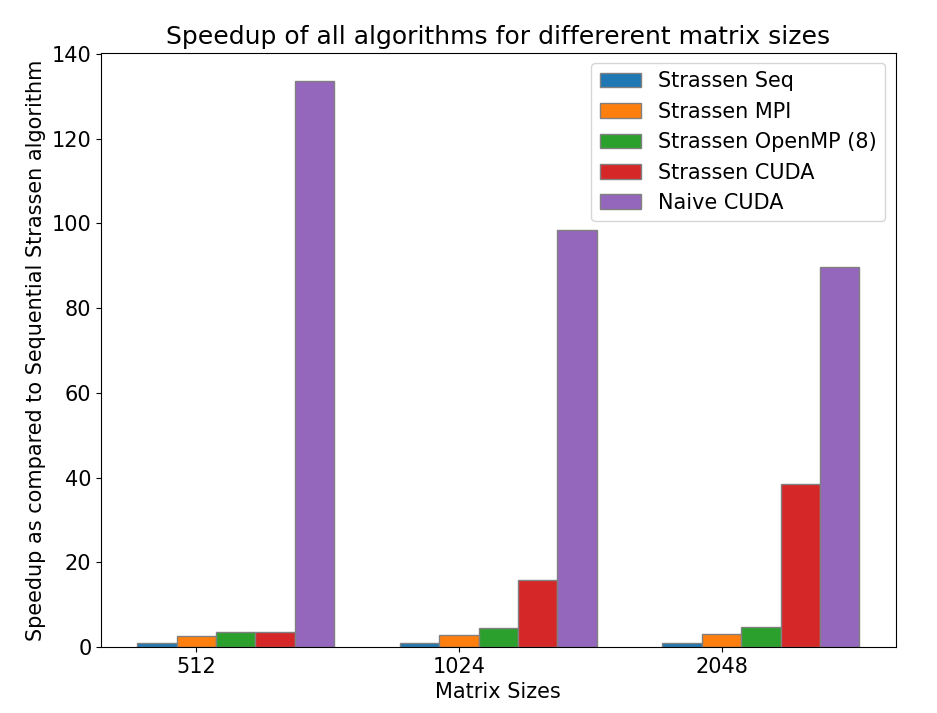

### Thank You!
